In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
carpeta = 'Training_2'

## Creacion de la matriz de target (Y)


Se leen las etiquetas de tiempo que pertenecen a la matriz HF, para posteriormente realizar una conversion a <b>int</b> debido a que los datos son <b>float</b> 


In [3]:
timeTicksHF = pd.read_csv(carpeta + '/TimeTicksHF.csv', header=None)
timeTicksHF = np.array(timeTicksHF.values).astype(int)

In [4]:
timeTicksHF

array([[1350889167],
       [1350889168],
       [1350889169],
       ...,
       [1350975562],
       [1350975563],
       [1350975564]])

Es necesario leer el archivo <b>TaggingInfo.csv</b> el cual contiene los aparatos que han sido encendidos durante la captura de la matriz HF. El archivo consta de cuatro columnas, la primera tiene el id del dispositivo, la segunda columna contiene el nombre del dispositivo, la tercera la etiqueta de tiempo en la cual se encendio el dispositivo y en la cuarta columna la etiqueta de tiempo en la cual el dispositivo fue apagado.

In [5]:
tagginginfo = pd.read_csv(carpeta + '/TaggingInfo.csv',header=None)
tagginginfo = tagginginfo.values
tagginginfo

array([[30, 'Outside Over Garage Lights', 1350939540, 1350939600],
       [30, 'Outside Over Garage Lights', 1350939660, 1350939720],
       [30, 'Outside Over Garage Lights', 1350939780, 1350939840],
       [29, 'Outside Front Door Lights', 1350939900, 1350939960],
       [29, 'Outside Front Door Lights', 1350940020, 1350940080],
       [29, 'Outside Front Door Lights', 1350940140, 1350940200],
       [15, 'Downstairs Hallway Lights', 1350940260, 1350940320],
       [15, 'Downstairs Hallway Lights', 1350940380, 1350940440],
       [15, 'Downstairs Hallway Lights', 1350940500, 1350940560],
       [34, 'Stairway Lights', 1350940620, 1350940680],
       [34, 'Stairway Lights', 1350940740, 1350940800],
       [34, 'Stairway Lights', 1350940860, 1350940920],
       [14, 'Downstairs Bathroom Lights', 1350941400, 1350941460],
       [14, 'Downstairs Bathroom Lights', 1350941520, 1350941580],
       [14, 'Downstairs Bathroom Lights', 1350941640, 1350941700],
       [12, 'Downstairs Bathroom F

Con la los archivos <b>TaggingInfo.csv</b> y <b>TimeTicksHF.csv</b> se crea la matriz target (y) la cual contiene un vector con los dispositivos encendidos
para cada espectro de frecuencias en la matriz HF. Por lo cual primero se crea una matriz de ceros de tamaño 37 x len(timeTicksHF), donde 37 es el número de
dispositivos y len(timeTicksHF) el el numero de espectros de frecuencia en la matriz HF.

In [6]:
target = np.zeros((38,len(timeTicksHF)))
target.shape

(38, 80998)

In [7]:
np.sum(target)

0.0

Para poder rellenar la matriz con unos en las zonas en las que estuvo encendido cada dispositivo, primero se realiza una traduccion de las etiquetas de tiempo a posiciones en la matriz. Esto es logrado por medio de la función <b>transTimeToIndx</b> la cual recibe tagginginfo, timeTicksHF, target, realiza una traduccion de las etiquetas de tiempo a indices (posiciones) en la matriz target.

In [8]:
def transTimeToIndx(tagging, Ticks, target):
    
    for ren in range(0,len(tagging)):
        
        id_device = tagging[ren,0]-1
        inicio, final = tagging[ren,2:]
        tamano = len(Ticks)
    
        for idx in range(0,len(Ticks)):
            if inicio<=Ticks[idx] and Ticks[idx]<=final:
                target[id_device, idx] = 1
            

In [9]:
transTimeToIndx(tagginginfo, timeTicksHF, target)

In [10]:
np.sum(target)

4307.0

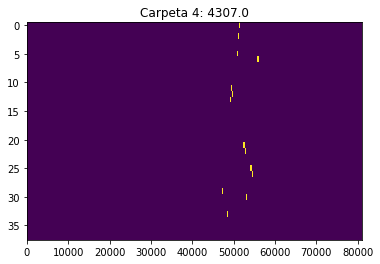

In [11]:
plt.imshow(target[:,:], aspect='auto')
plt.title('Carpeta 4: '+str(np.sum(target)))
plt.show()

Como es posible apreciar en el imagen anterior la mayoria del tiempo no hay dispositivos encendidos, por lo cual es posible dejar de tomar en cuenta los vectores en los cuales ningún aparato se encuentra encendido, quedandonos con los vectores verdaderamente reelevantes, la manera de identificarlos es relativamente sencilla, solo es necesario obtener la suma de sus componenetes, si la suma es cero ningun aparato estuvo encendido por tanto es descartado. De los vactores vacios en los que no se encuentran encendidos dispositivos se toman un cierto porcentaje con la finalidad de que el modelo de machine learning aprenda a identificar cuando no hay dispositivos encendidos.

De esta manera se crea la función clean que se encarga de limpiar la matriz HF y la matriz target 

In [12]:
def clean(HF, target, porcent):
    idx = [i for i in range(0,len(target.T)) if np.sum(target[:,i]) != 0]
    tam = int(porcent*len(idx)/100)
    cont = 0
    
    for i in range(0,int(len(target.T)/2)):
        if 0 == np.sum(target[:,2*i]):
            idx.append(2*i)
        if cont >= tam:
            break
        cont+=1
        
    target2 = np.array([target[:,i] for i in idx]).T
    HF2 = np.array([HF[:,i] for i in idx]).T
    
    return HF2, target2

Se lee la matriz HF desde el archivo <b>HF.csv</b> para eliminar los vectores que no contengan informacion reelevante

In [13]:
%%time
HF = pd.read_csv(carpeta + '/HF.csv',header=None)
HF = HF.values
HF.shape

Wall time: 9min 3s


(4096, 80998)

In [14]:
X, y = clean(HF, target, 10)
print(X.shape)
print(y.shape)

(4096, 4738)
(38, 4738)


In [15]:
%%time
np.savetxt('X_'+carpeta+'.csv', X, delimiter=",")
np.savetxt('y_'+carpeta+'.csv', y, delimiter=",")

Wall time: 14.1 s


De las matrices HF con componentes reelevantes, se crea una matriz reducida la cual es submuestreada tomando cada 2 componentes de frecuencia 

Posterior a limpiar el resultado es guardado en archivos csv.